# Imports

In [11]:
import os
from functools import partial
import json
import csv

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

# Downloading state data

In [12]:
graph_path = "./utah.json"
graph = Graph.from_json(graph_path)
with open (graph_path, "r") as myfile:
    data=myfile.readlines()
graph_dict = json.loads(data[0])

# Chain stuff

In [13]:
pop_count = 0

for i in graph.nodes:
    pop_count += graph.nodes[i]["TOTPOP"]
    
print(pop_count)

2764056.0566752497


In [22]:
graph.nodes[0]

{'boundary_node': True,
 'boundary_perim': 2498.664338104136,
 'area': 751464858.6173844,
 'CountyID': 7,
 'VistaID': 'DU11',
 'PrcncID': 'DU11',
 'SbPrcnc': None,
 'AliasNm': None,
 'DsslvID': '7PDU11',
 'cnty_nm': 'Duchesne County',
 'cnty_fp': 49013,
 'jrsdctn': 'Duchesne',
 'PRES16D': 20.0,
 'PRES16R': 219,
 'PRES16I': 17,
 'SEN16D': 27,
 'SEN16R': 221,
 'GOV16D': 24,
 'GOV16R': 215,
 'TOTPOP': 504.4102544747859,
 'NH_WHITE': 430.29685596634425,
 'NH_BLACK': 0.004635374238234,
 'NH_AMIN': 1.01699533316232,
 'NH_ASIAN': 1.001545124746078,
 'NH_NHPI': 0.004635374238234,
 'NH_OTHER': 5.473073877000391,
 'NH_2MORE': 6.001544832824667,
 'HISP': 60.610968592231686,
 'H_WHITE': 18.991745359867213,
 'H_BLACK': 0.004635374238234,
 'H_AMIN': 3.003090249492156,
 'H_ASIAN': 0.003090249492156,
 'H_NHPI': 0.0,
 'H_OTHER': 36.25389455933765,
 'H_2MORE': 2.354512799804279,
 'VAP': 337.0797582972571,
 'HVAP': 33.244119822079185,
 'WVAP': 298.57512561836774,
 'BVAP': 0.004635374238234,
 'AMINVAP': 1

In [15]:
f = csv.writer(open("test.csv", "wb+"))

In [24]:
# f.writerow(["dem_votes", "rep_votes", "prec_pop", "node_num"])

for n in graph.nodes:
    f.writerow([graph.nodes[n]["SEN16D"],
              graph.nodes[n]["SEN16R"],
              graph.nodes[n]["TOTPOP"],
              graph.nodes[n]["PrcncID"]])

TypeError: a bytes-like object is required, not 'str'

In [37]:
graph.nodes[0]

{'boundary_node': True,
 'boundary_perim': 2498.664338104136,
 'area': 751464858.6173844,
 'CountyID': 7,
 'VistaID': 'DU11',
 'PrcncID': 'DU11',
 'SbPrcnc': None,
 'AliasNm': None,
 'DsslvID': '7PDU11',
 'cnty_nm': 'Duchesne County',
 'cnty_fp': 49013,
 'jrsdctn': 'Duchesne',
 'PRES16D': 20.0,
 'PRES16R': 219,
 'PRES16I': 17,
 'SEN16D': 27,
 'SEN16R': 221,
 'GOV16D': 24,
 'GOV16R': 215,
 'TOTPOP': 504.4102544747859,
 'NH_WHITE': 430.29685596634425,
 'NH_BLACK': 0.004635374238234,
 'NH_AMIN': 1.01699533316232,
 'NH_ASIAN': 1.001545124746078,
 'NH_NHPI': 0.004635374238234,
 'NH_OTHER': 5.473073877000391,
 'NH_2MORE': 6.001544832824667,
 'HISP': 60.610968592231686,
 'H_WHITE': 18.991745359867213,
 'H_BLACK': 0.004635374238234,
 'H_AMIN': 3.003090249492156,
 'H_ASIAN': 0.003090249492156,
 'H_NHPI': 0.0,
 'H_OTHER': 36.25389455933765,
 'H_2MORE': 2.354512799804279,
 'VAP': 337.0797582972571,
 'HVAP': 33.244119822079185,
 'WVAP': 298.57512561836774,
 'BVAP': 0.004635374238234,
 'AMINVAP': 1

In [43]:
%%time
num_dist = 4

# Exercise: Compute exact population from your data.
pop = pop_count

my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    "SEN16": Election("SEN16", {"democratic":"SEN16D","republican":"SEN16R"}),
    "PRES16": Election("SEN16", {"democratic":"PRES16D","republican":"PRES16R"}),
    "GOV16": Election("SEN16", {"democratic":"GOV16D","republican":"GOV16R"})
}


new_plan = recursive_tree_part(graph,
                               range(num_dist),
                               pop/num_dist,
                               "TOTPOP",
                               0.004,
                               1)
initial_partition = Partition(graph,
                              new_plan,
                              my_updaters)

CPU times: user 47.1 s, sys: 351 ms, total: 47.5 s
Wall time: 54.2 s


In [44]:
%%time
proposal = partial(recom,
                   pop_col = "TOTPOP",
                   pop_target = pop/num_dist,
                   epsilon = 0.01,
                   node_repeats = 3)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

CPU times: user 15 ms, sys: 6.07 ms, total: 21.1 ms
Wall time: 22.2 ms


In [45]:
%%time
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.01),
        compactness_bound,
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=10000,
)

CPU times: user 10.4 ms, sys: 6.34 ms, total: 16.8 ms
Wall time: 17.6 ms


In [46]:
%%time

data = []

for step in tqdm_notebook(chain):
    data.append([step["SEN16"].wins("republican"),
                         mean_median(step["SEN16"]),
                         partisan_gini(step["SEN16"]),
                         step["SEN16"].percents("republican")])

CPU times: user 4h 43min 8s, sys: 58.7 s, total: 4h 44min 7s
Wall time: 5h 15min 23s


# Visualization

CPU times: user 325 ms, sys: 17.6 ms, total: 342 ms
Wall time: 431 ms


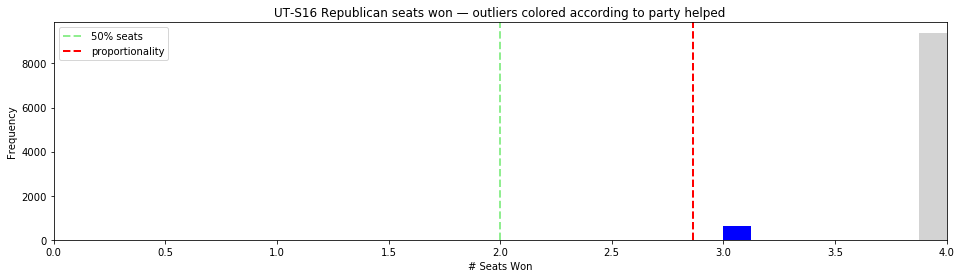

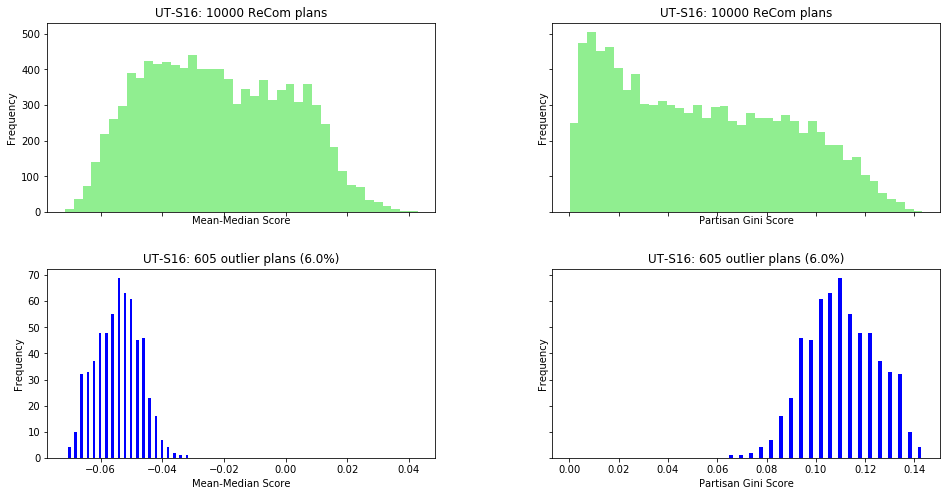

In [96]:
%%time
# fig, votes = plt.subplots(figsize=(16,4))
fig, seats = plt.subplots(figsize=(16,4))
fig, ax = plt.subplots(2,2, figsize=(16,8), sharex="col", sharey="row")

plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Variables
inliers = [4,4]
bins_num = 20
out_bins_num = 8
title = "UT-S16: 10000 ReCom plans"

# Colors
seats_colors = ["red", "blue", "lightgray"]
party_colors = ["red", "blue"]
neutral = "lightgreen"

# Creating Datasets
mm = []
pg = []
vs = []
mm_routliers = []
mm_doutliers = []
pg_routliers = []
pg_doutliers = []
seats_routliers = []
seats_doutliers = []
seats_inliers = []
vs_routliers = []
vs_doutliers = []


for plan in tqdm_notebook(data):
    mm.append(plan[1])
    pg.append(plan[2])
    vs.append(plan[3])
    if plan[0] < inliers[0]:
        seats_doutliers.append(plan[0])
        mm_doutliers.append(plan[1])
        pg_doutliers.append(plan[2])
        vs_doutliers.append(plan[3])
    if plan[0] > inliers[1]:
        seats_routliers.append(plan[0])
        mm_routliers.append(plan[1])
        pg_routliers.append(plan[2])
        vs_routliers.append(plan[3])
    if plan[0] >= inliers[0] and plan[0] <= inliers[1]:
        seats_inliers.append(plan[0])

mms = [mm_routliers, mm_doutliers]
pgs = [pg_routliers, pg_doutliers]
seats_colored = [seats_routliers, seats_doutliers, seats_inliers]

# More variables
num_outliers = str(len(mm_doutliers) + len(mm_routliers))
pct_outliers = str(round((len(mm_doutliers) + len(mm_routliers)) / 10000 * 100, 1))
title_w = "UT-S16: " + num_outliers + " outlier plans " + "(" + pct_outliers + "%)"

# Plotting the votes shares boxplots
# votes.boxplot(vs, positions=range(len(data.columns)))

# votes.set_title("Votes Shares Boxplots")
# votes.set_ylabel("Republican Votes %")
# votes.set_xlabel("District #")


# Plotting the seats histogram
seats.hist(seats_colored, bins=out_bins_num, stacked=True, color=seats_colors)

seats.set_title("UT-S16 Republican seats won — outliers colored according to party helped")
seats.set_ylabel("Frequency")
seats.set_xlabel("# Seats Won")
seats.set_xlim(0, num_dist)
seats.axvline(x = num_dist/2, color=neutral, linestyle="dashed", linewidth=2, label="50% seats")
seats.axvline(x = num_dist * initial_partition["SEN16"].percent("republican"), color="red", linestyle="dashed", linewidth=2, label="proportionality")
seats.legend()
# seats.set_xticks(1)

# Plotting the whole dataset
ax[0,0].hist(mm, bins=2*bins_num, color=neutral)
ax[0,1].hist(pg, bins=2*bins_num, color=neutral)

ax[0,0].set_title(title)
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_xlabel("Mean-Median Score")

ax[0,1].set_title(title)
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_xlabel("Partisan Gini Score")

# Plotting the winnowed data
ax[1,0].hist(mms, bins=bins_num, color=party_colors)
ax[1,1].hist(pgs, bins=bins_num, color=party_colors)
# ax[1,1].set_ylim((0,40))

ax[1,0].set_title(title_w)
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_xlabel("Mean-Median Score")

ax[1,1].set_title(title_w)
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_xlabel("Partisan Gini Score")

In [114]:
data[-1]

[4,
 0.04293481221847356,
 0.08586962443694712,
 (0.6743104080419469,
  0.6731874325722715,
  0.6718004121401276,
  0.847436677347985)]

In [70]:
vs[900]

(0.6616554664620877, 0.7851893610635692, 0.759585376727597, 0.662973847997174)

In [57]:
sum(vs_doutliers[24])/4

0.7089667646177904

In [83]:
mm_doutliers_hopefully = []

for i in range(len(vs_doutliers)):
    mm_doutliers_hopefully.append(((sorted(vs_doutliers[i])[1] + sorted(vs_doutliers[i])[2]) / 2) - (sum(vs_doutliers[i])/4))
    
mm_doutliers_hopefully

[0.045635560490212335,
 0.05289755358293713,
 0.051564639811879864,
 0.04751162672656162,
 0.049223079323232,
 0.04392536892938392,
 0.043642553320708655,
 0.055057015572070545,
 0.0494847689960598,
 0.05155676205221271,
 0.051345986575232705,
 0.04793150861099704,
 0.05244982931207631,
 0.06407615486407903,
 0.04876563156813618,
 0.04880768147832559,
 0.05608066568257741,
 0.04371730684961117,
 0.05678566460783008,
 0.06044238248398481,
 0.06579492743157944,
 0.05905399844573456,
 0.060952488188452336,
 0.05376071057889964,
 0.062049824647057106,
 0.05198148597003949,
 0.05341776205204385,
 0.05545055479731131,
 0.053695117106649315,
 0.04920798874886101,
 0.047990646999686914,
 0.06345142433286677,
 0.0624658834280567,
 0.06009636319284006,
 0.05049888004891634,
 0.04607417175608186,
 0.04828573280743864,
 0.05151346337941154,
 0.060503455939845185,
 0.049545154869376495,
 0.05024971100522657,
 0.050307547486926674,
 0.06600147247763033,
 0.05162510354603589,
 0.052405507133452156,
 

(array([ 1.,  1.,  2.,  4.,  7., 16., 23., 46., 45., 61., 63., 69., 55.,
        48., 48., 37., 33., 32., 10.,  4.]),
 array([0.03146752, 0.03347514, 0.03548276, 0.03749038, 0.039498  ,
        0.04150562, 0.04351324, 0.04552086, 0.04752848, 0.04953609,
        0.05154371, 0.05355133, 0.05555895, 0.05756657, 0.05957419,
        0.06158181, 0.06358943, 0.06559705, 0.06760467, 0.06961229,
        0.0716199 ]),
 <a list of 20 Patch objects>)

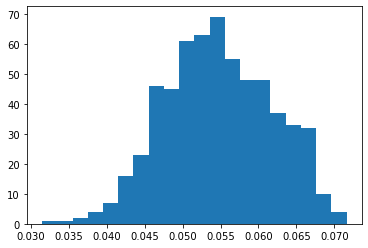

In [85]:
fig, test = plt.subplots(figsize=(6,4))

test.hist(mm_doutliers_hopefully, bins=bins_num)

In [104]:
mm_doutliers_hopefully = []

for i in vs_doutliers:
    dem_vs = [(1-k) for k in i]
    mm_doutliers_hopefully.append(((sorted(dem_vs)[1] + sorted(dem_vs)[2]) / 2) - (sum(dem_vs)/4))
    
    
mm_doutliers_hopefully

[-0.045635560490212335,
 -0.05289755358293702,
 -0.051564639811879864,
 -0.04751162672656156,
 -0.049223079323232055,
 -0.04392536892938392,
 -0.043642553320708655,
 -0.055057015572070545,
 -0.04948476899605969,
 -0.05155676205221266,
 -0.05134598657523265,
 -0.04793150861099715,
 -0.05244982931207631,
 -0.06407615486407914,
 -0.048765631568136236,
 -0.04880768147832565,
 -0.05608066568257747,
 -0.043717306849611226,
 -0.05678566460783002,
 -0.06044238248398481,
 -0.06579492743157939,
 -0.059053998445734446,
 -0.060952488188452336,
 -0.05376071057889953,
 -0.06204982464705705,
 -0.05198148597003949,
 -0.053417762052043904,
 -0.05545055479731126,
 -0.05369511710664948,
 -0.049207988748861065,
 -0.04799064699968686,
 -0.06345142433286693,
 -0.062465883428056646,
 -0.06009636319283995,
 -0.050498880048916284,
 -0.04607417175608186,
 -0.048285732807438586,
 -0.05151346337941143,
 -0.06050345593984524,
 -0.049545154869376606,
 -0.05024971100522663,
 -0.050307547486926785,
 -0.06600147247763

(array([ 4., 10., 32., 33., 37., 48., 48., 55., 69., 63., 61., 45., 46.,
        23., 16.,  7.,  4.,  2.,  1.,  1.]),
 array([-0.0716199 , -0.06961229, -0.06760467, -0.06559705, -0.06358943,
        -0.06158181, -0.05957419, -0.05756657, -0.05555895, -0.05355133,
        -0.05154371, -0.04953609, -0.04752848, -0.04552086, -0.04351324,
        -0.04150562, -0.039498  , -0.03749038, -0.03548276, -0.03347514,
        -0.03146752]),
 <a list of 20 Patch objects>)

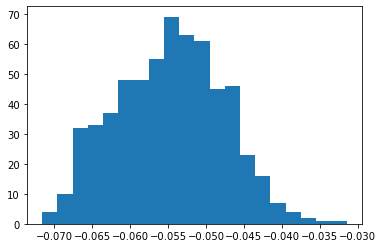

In [106]:
fig, test = plt.subplots(figsize=(6,4))

test.hist(mm_doutliers_hopefully, bins=bins_num)